In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

from dataloaders.osm_dataloader import OSMDataset
from dataloaders.osm_datagenerator import DataGeneratorOSM
from dataloaders.dataset_helper import findallimagesosm

from models.Unet_keras import buildUnet
from dataloaders.img_helper import show_sample, show_sample_gt


Using TensorFlow backend.


In [2]:
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#functions for the loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# Dataset loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


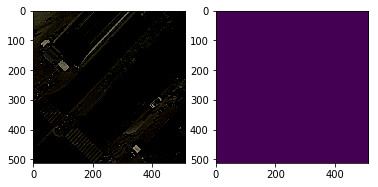

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


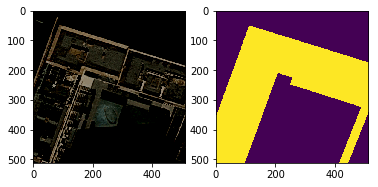

In [4]:
 # Datasets
partition, labels = findallimagesosm(folder = '/data/khokhlov/datasets/OSM_processed_margo/')

params = {'dim': (512, 512),
          'batch_size': 10,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': True}
max_epochs = 100

training_generator = DataGeneratorOSM(partition['train'], labels['train'], **params)
validation_generator = DataGeneratorOSM(partition['validation'], labels['validation'], **params)

(X,y) = training_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))

(X,y) = validation_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))


## Training parameters

In [5]:
loss_history = []
weight_path = "modelssaved/{}_weights.best.hdf5".format('vgg_unet')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)  # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]




## Model

In [6]:
unet_model = buildUnet(X, y) # to initialize the parameters correctly
unet_model.compile(optimizer=Adam(1e-3, decay=1e-6),
                   loss=dice_p_bce,
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [ ]:

loss_history += [unet_model.fit_generator(generator=training_generator, steps_per_epoch=200,
                                          epochs=50,
                                          validation_data=validation_generator, validation_steps=200,
                                          use_multiprocessing=False,
                                          callbacks=callbacks_list)]

Epoch 1/50
200/200 [==============================] - 242s 1s/step - loss: -0.6145 - dice_coef: 0.6145 - binary_accuracy: 0.3364 - true_positive_rate: 0.9970 - val_loss: -0.5493 - val_dice_coef: 0.5493 - val_binary_accuracy: 0.2484 - val_true_positive_rate: 1.0000

Epoch 00001: val_loss improved from inf to -0.54933, saving model to modelssaved/vgg_unet_weights.best.hdf5
Epoch 2/50
200/200 [==============================] - 235s 1s/step - loss: -0.6178 - dice_coef: 0.6178 - binary_accuracy: 0.3391 - true_positive_rate: 1.0000 - val_loss: -0.5555 - val_dice_coef: 0.5555 - val_binary_accuracy: 0.2569 - val_true_positive_rate: 1.0000

Epoch 00002: val_loss improved from -0.54933 to -0.55550, saving model to modelssaved/vgg_unet_weights.best.hdf5
Epoch 3/50
200/200 [==============================] - 235s 1s/step - loss: -0.6216 - dice_coef: 0.6216 - binary_accuracy: 0.3438 - true_positive_rate: 1.0000 - val_loss: -0.5585 - val_dice_coef: 0.5585 - val_binary_accuracy: 0.2604 - val_true_posi

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [11]:
unet_model.load_weights(weight_path)
unet_model.save('full_seg_model.h5')

## Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


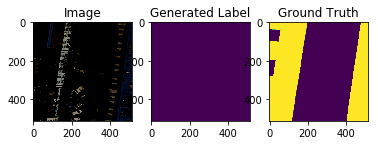

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


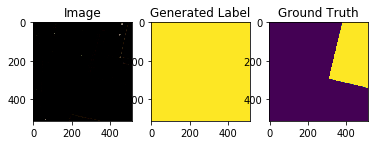

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


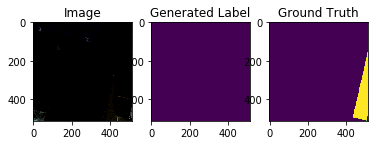

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


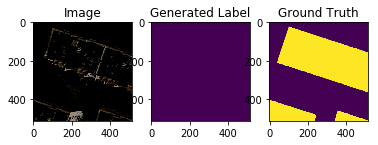

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


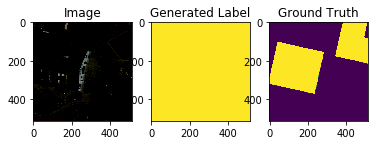

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


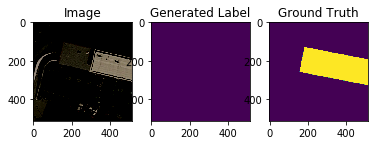

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


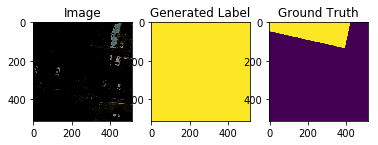

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


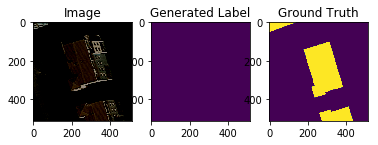

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


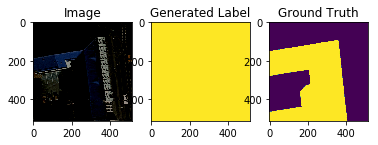

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


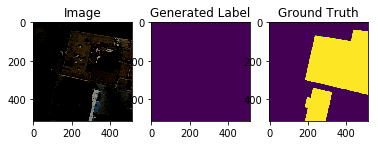

In [8]:
%load_ext autoreload
%autoreload 2
testing_generator = DataGeneratorOSM(partition['test'], labels['test'], **params)
(X,y) = testing_generator. __getitem__(0)
dm_pred = unet_model.predict([X])
for i in range(dm_pred.shape[0]):
    show_sample_gt(X[i,:].astype(int), np.squeeze(dm_pred[i,:]), np.squeeze(y[i,:]))
    
